# LangGraph Pipeline with LangFuse

Import packages.

In [ ]:
import os
import pandas as pd

from datetime import datetime
from dotenv import load_dotenv
from json import loads, dumps
from langchain.tools import tool


from pydantic import BaseModel, Field
from typing import Annotated, Sequence, TypedDict, Literal

from IPython.display import Image, display


from langchain_core.messages import BaseMessage, HumanMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate

from langchain_openai import OpenAIEmbeddings, ChatOpenAI

from langfuse import Langfuse, get_client
from langfuse.langchain import CallbackHandler
from langfuse.openai import openai  # Don't delete this line.

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import START, END, StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import tools_condition, ToolNode

Set up environment variables.

In [2]:
# Set up environment variables.
load_dotenv(override=True)
openai_api_key = os.getenv('OPENAI_API_KEY')

# Monitor if the environment variables are ready.
if openai_api_key:
    print(f"OpenAI API Key exists and begins {openai_api_key[:8]}")
else:
    print("OpenAI API Key not set - please head to the troubleshooting guide in the setup folder")

OpenAI API Key exists and begins sk-proj-


In [3]:
langfuse_secret_key = os.getenv('LANGFUSE_SECRET_KEY')
langfuse_public_key = os.getenv('LANGFUSE_PUBLIC_KEY')
langfuse = Langfuse(
    secret_key = langfuse_secret_key,
    public_key = langfuse_public_key,
    host="https://cloud.langfuse.com"
    # host = "https://us.cloud.langfuse.com"
)

langfuse = get_client()
 
# Verify connection
if langfuse.auth_check():
    print("Langfuse client is authenticated and ready!")
else:
    print("Authentication failed. Please check your credentials and host.")

Langfuse client is authenticated and ready!


In [4]:
completion = openai.chat.completions.create(
  name="test-chat",
  model="gpt-4o",
  messages=[
      {"role": "system", "content": "You are a very accurate calculator. You output only the result of the calculation."},
      {"role": "user", "content": "1 + 1 = "}],
  metadata={"someMetadataKey": "someValue"},
)

Define supporting variables and functions.

In [5]:
def format_job_descriptions(jd_dataframe):
    if isinstance(jd_dataframe, pd.Series):
        jd_dataframe = jd_dataframe.to_frame().T
    result = jd_dataframe.to_json(orient='records')
    return result

Function test.

In [6]:
df = pd.read_csv("data/X_test.csv")
test = df.iloc[0, :]
if isinstance(test, pd.Series):
        test = test.to_frame().T
json_records = test.to_json(orient='records')
parsed = loads(json_records)
print(dumps(parsed, indent=4) )

[
    {
        "title": "Driver / Tour Guide for Coach & 4WD Coach Tours",
        "abstract": "This role includes conducting 1-20 Day Tours to a range of locations all over Australia with mature passengers for a well established family company.",
        "job_description_clean": "Casey Australia Tours require a experienced Coach Drivers / Tour Guide for the rest of the 2019 season of extended motel and/or camping tours starting mid/late June The role requires driving, minor coach maintenance, cleaning, guiding and commentating plus some cooking. The ideal person should have; 1. A sense of humour and engaging personality 2. Initiative and problem solving skills 3. Confidence and be a good public speaker 4. A current manual HR drivers licence with F endorsement. (or ability to get one quickly) 5. A safe driving record 6. Clear Criminal History 7. Experience in some field that can be related 8. First Aid Training 9. Good Navigation in remote and city areas Handy assets to have; 1. Mecha

Define Graph Sate.

In [7]:
class AgentState(TypedDict):
    """
    Represents the state of graph.

    Attributes:
        messages: A list of messages in the conversation, including user input and agent outputs.

    Notes:
        The add_messages function defines how an update should be processed.
        Default is to replace. add_messages says "append".
    """
    messages: Annotated[Sequence[BaseMessage], add_messages]

Deinfe Basic Nodes.

Input: job description strings.

Host node

Conditional Edge: whether the question is about to check job descriptions.

If not, return generate.

If yes, go to next node.

Get industry information and professional skills.

Get general requirements.

Evaluate the job advertisement.

Refine the job advertisement.



In [8]:
def host_agent(state):
    """
    Invokes the whole workflow and monitor the state.

    Args:
        state (messages): The current state

    Returns:
        dict: The updated state with the agent response appended to messages
    """
    
    print("---CALL HOST AGENT---")
    messages = state["messages"][-1].content
    
    model = ChatOpenAI(temperature=0, streaming=True, model="gpt-4-turbo")
    response = model.invoke(messages)
    
    return {"messages": [response]}

In [9]:
def industry_agent(state, config):
    """
    Generate answer. The core of RAG.

    Args:
        state (messages): The current state

    Returns:
         dict: The updated state with re-phrased question
    """
    print("---CALL INDUSTRY AGENT---")

    # Prompt
    prompt = PromptTemplate(
        template="""
            You are a helpful assistant that extracts structured information from a given job advertisements.

            Input job ad:
            {job_text}

            Instruction:
            Extract the following fields from the given job advertisement. If a field is not present, return an empty list for that field.

            - skills: short list of skills, tools, technologies (e.g., "Python", "SQL", "scikit-learn", "communication")
            - responsibilities: short concise list of responsibilities / duties described in the ad
            - requirements: candidate requirements such as experience, qualifications, degrees, certifications, years of experience

            Return a JSON objects ONLY and MUST with keys: "job_title", "skills", "responsibilities", "requirements", "classification", "salary", "location", "workType".  

            Example:
            {{"job_title": ["Data Scientist"], "skills": ["Python", "SQL"], "responsibilities": ["build predictive models"], "requirements": ["3+ years experience", "Bachelor's degree"], "classification":["Information & Communication Technology"], "salary":["150,000 AUD"], "location":["Sydney"], "workType":["Fulltime"]}}
        """,
        input_variables=["job_text"],
    )

    # LLM
    llm = ChatOpenAI(model_name="gpt-4-turbo", temperature=0, streaming=True)

    # Chain
    chain = prompt | llm | StrOutputParser()

    # Run
    response = chain.invoke({"job_text": config["configurable"]["job_ads"][-1]})
    return {"messages": [response]}

In [10]:
def check_task_agent(state, config) -> Literal["industry_agent", "END"]:
    """
    Determines whether the question is about to check job descriptions.

    Args:
        state (messages): The current state

    Returns:
        str: A decision for whether the question is about to check job descriptions.
    """

    print("---CHECK TASK RELEVANCE---")

    
    if config["configurable"]["job_ads"][-1] is not None and len(config["configurable"]["job_ads"][-1]) >= 1:
        print("---DECISION: This is a job advertisement analysis task. ---")
        return "industry_agent"

    else:
        print("---DECISION: This is not a job advertisement analysis task.---")
        print("PLEASE INPUT JOB DESCRIPTIONS.")
        return "END"

In [11]:
def evaluate_agent(state, config):
    """
    Generate answer. The core of RAG.

    Args:
        state (messages): The current state

    Returns:
         dict: The updated state with re-phrased question
    """
    print("---CALL EVALUATE AGENT---")
    messages = state["messages"]
    job_message = messages[-1]
    job_message_docs = job_message.content

    # Prompt
    prompt = PromptTemplate(
        template="""
            You are a helpful assistant that can evaluate the job advertisement information and give improve suggestions.

            Input job advertisement information:
            {job_message_docs}

            Instruction:
            Based on the current information, list the lacked part of job advertisement and the improved suggestion.
            
            Return a JSON object ONLY and MUST with keys: "skills_evaluate", "responsibilities_evaluate", "requirements_evaluate", "classification_evaluate", "salary_evaluate", "location_evaluate", "workType_evaluate". 

            No other strings outside JSON objects.

            Example:

            {{"skills_evaluate":["Can be more clear", "Python, SQL, GCP"], "salary_evaluate":["Missed", "Competitive Salary"], "location_evaluate":["Missed"], "workType_evaluate":["Missed"]}}
        """,
        input_variables=["job_message_docs"],
    )

    # LLM
    llm = ChatOpenAI(model_name="gpt-4-turbo", temperature=0, streaming=True)

    # Chain
    chain = prompt | llm | StrOutputParser()

    # Run
    response = chain.invoke({"job_message_docs": job_message_docs})
    return {"messages": [response]}

Complie the graph.

In [117]:
# Define a new graph
workflow = StateGraph(AgentState)

# Define the nodes.
workflow.add_node("host_agent", host_agent)  
workflow.add_node("industry_agent", industry_agent)  
workflow.add_node("evaluate_agent", evaluate_agent)  

# Call agent node to decide to retrieve or not
workflow.add_edge(START, "host_agent")
workflow.add_conditional_edges(
    "host_agent", 
    check_task_agent, 
    {
        "END": END,                         # map this label to the END
        "industry_agent": "industry_agent", # map this one to a node
    })
workflow.add_edge("industry_agent", "evaluate_agent")
workflow.add_edge("evaluate_agent", END)

# Compile
graph = workflow.compile(checkpointer=MemorySaver())


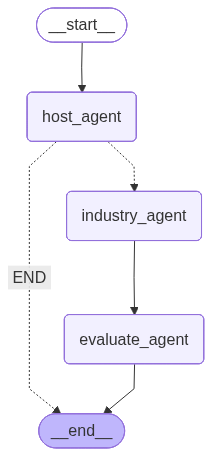

In [118]:
try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    pass

In [119]:
def agent_invoke(graph, question, job_ads, config):
    """
    Invoke the workflow with user question, generate human-friendly metrics and answers.

    Args:
        graph: The current workflow
        question: The user input to invoke the workflow
        config: The holder of thread, memory, and LangFuse

    Returns:
        retriever_counter: how many times the retriever tool is called for this question
        rewrite_counter: how many times the question is rewritten, which indicates a failed retrieval
        final_message: the answer that can be shown to all audience
    """
    # config["configurable"]["questions"].append(question)
    config["configurable"]["job_ads"].append(job_ads)

    analysis_message = []
    evaluate_message = []

    inputs = {
        "messages":[
            ("user", question)
        ]
    }

    for output in graph.stream(inputs, config=config):
        for key, value in output.items():
            # For Agent node, output tool call information.
            if key == 'host_agent':
                print("host_agent")
                # final_message = final_message + value['messages'][0].content
                print(value['messages'][0].content)
            # For retrieve tool node, counter plus.
            elif key == 'industry_agent':
                print("industry_agent")
                # final_messsage = final_message + value['messages'][0]
                print(value['messages'][0])
                analysis_message.append(value['messages'][0])

            elif key == 'evaluate_agent':
                print("evaluate_agent")
                # final_messsage = final_message + value['messages'][0]
                print(value['messages'][0])
                evaluate_message.append(value['messages'][0])
                print("\n---END QUESTION---")
            else:
                pass
    return analysis_message, evaluate_message

In [120]:
def deal_with_single_question(logs, graph, question, job_ads, config):
    """
    Deal with the workflow inputs and outputs, push them into local logging system.

    Args:
        logs: the list to store key information and metrics for the whole thread
        graph: The current workflow
        question: The user input to invoke the workflow
        config: The holder of thread, memory, and LangFuse
    """
    # Get the current date and time for time stamp.
    invoke_datetime = datetime.now().strftime("%Y%m%d_%H%M%S")
    thread_id = config['configurable']['thread_id']


    analysis_message, evaluate_message = agent_invoke(graph, question, job_ads, config)
    return invoke_datetime, thread_id, analysis_message, evaluate_message
    

Use case test.

In [121]:
# Put LangFuse Handler when the workflow is invoked.
# Set up functions.
langfuse_handler = CallbackHandler()

In [122]:
train_df = pd.read_csv("data/X_train.csv")
sample_df = df.sample(n=50, random_state=42)

In [123]:
logs = []

for i in range(0, 50):
    if i%5 == 0:
        thread_id_str = "loop-test-"+str(i/5)
        config = {"configurable": {"thread_id": thread_id_str, "questions": [], "job_ads":[], "callbacks": [langfuse_handler]}}
        
    
    row_df = sample_df.iloc[i,:]
    json_records = row_df.to_json(orient='records')
    invoke_datetime, thread_id, analysis_message, evaluate_message = deal_with_single_question(logs, graph, "Hi, I'm Alexandra. Please help me analyse following job advertisements", json_records, config)
    if not analysis_message or not evaluate_message:
        continue
    analysis_dict = loads(analysis_message[0])
    analysis_df = pd.DataFrame([analysis_dict])
    evaluate_dict = loads(evaluate_message[0])
    evaluate_df = pd.DataFrame([evaluate_dict])
    single_result = pd.concat([analysis_df, evaluate_df], axis=1)
    single_result["invoke_datetime"] = invoke_datetime
    single_result["thread_id"] = thread_id
    logs.append(single_result)

---CALL HOST AGENT---
---CHECK TASK RELEVANCE---
---DECISION: This is a job advertisement analysis task. ---
host_agent
Hello Alexandra! I'd be happy to help you analyze the job advertisements. Please provide the details of the job ads you're interested in, and let me know what specific aspects you'd like to focus on (e.g., job requirements, qualifications, company culture, etc.).
---CALL INDUSTRY AGENT---
industry_agent
{
    "job_title": ["Associate / Territory Manager, Trauma (Newcastle)"],
    "skills": [
        "sales savvy",
        "technical agility",
        "interpersonal skills",
        "planning",
        "execution",
        "decision making",
        "interpret financial and clinical data"
    ],
    "responsibilities": [
        "responsible and accountable for business growth within the Newcastle territory",
        "maximising sales of Smith & Nephew Trauma equipment, products and services",
        "regular contact with the target customer base",
        "develop an

In [124]:
log_df = pd.concat(logs, axis=0)
log_df

,job_title,skills,responsibilities,requirements,classification,salary,location,workType,skills_evaluate,responsibilities_evaluate,requirements_evaluate,classification_evaluate,salary_evaluate,location_evaluate,workType_evaluate,invoke_datetime,thread_id
0,"[Associate / Territory Manager, Trauma (Newcas...","[sales savvy, technical agility, interpersonal...",[responsible and accountable for business grow...,[Tertiary qualifications in Science or Busines...,"[Healthcare & Medical, Sales]",[],"[Newcastle, Maitland & Hunter, Newcastle]",[Full Time],[Consider adding specific software or tools us...,[Clarify how often the candidate will need to ...,[Include soft skills such as communication or ...,[Add more specific sub-categories if applicabl...,"[Missed, Include a salary range or state that ...",[Clarify if the role requires relocation or if...,[Specify if there are any flexible working opt...,20251025_192703,loop-test-0.0
0,[Customer Service - Entry Level Banking],"[customer service, sales, negotiating, problem...",[providing solutions for clients and customers...,"[ambitious, customer focused attitude, ability...",[Call Centre & Customer Service],[],[Sydney],[Full Time],[Consider adding specific software or systems ...,[Include more specific examples of daily tasks...,[Specify the level of experience required in s...,[Classification is clear but could be expanded...,[Salary details are missing. It is recommended...,"[Location is specified, but it could be enhanc...","[Work type is mentioned, but it could be benef...",20251025_192718,loop-test-0.0
0,[HR Generalist],"[case management, compliance, grievances, empl...",[partners with people leaders in the managemen...,[Tertiary qualification in Human Resources or ...,[Human Resources & Recruitment],"[$85,200K plus super]","[Bayside & South Eastern Suburbs, Melbourne]",[Full Time],[Consider adding specific software or tools us...,[Specify the types of HR matters to give candi...,[Include requirements for specific certificati...,[Add more specific sub-categories if applicabl...,"[Clarify if '$85,200K' is a typo and meant to ...","[Specify if remote work options are available,...",[Mention if there are flexible working hours o...,20251025_192730,loop-test-0.0
0,[Experienced Legal Secretaries],"[legal secretarial experience, typing, compute...",[],"[Minimum 2 years legal secretarial experience,...",[Legal],[],"[CBD, Inner West & Eastern Suburbs, Sydney]",[Full Time],[Consider adding specific software skills (e.g...,"[Missed, List specific duties such as drafting...",[Consider specifying educational qualification...,[Consider adding more specific sub-classificat...,"[Missed, Provide a salary range or indicate th...",[Clear],[Clear],20251025_192742,loop-test-0.0
0,[Planning & Environment Lawyer/Senior Associate],"[litigation, advisory]","[dealing with local councils, direct client co...","[2-10 PAE, experience in planning and environm...",[Legal],[],[Melbourne],[Full Time],"[Add more specific skills, Consider including ...","[Add more detailed responsibilities, Include r...","[Specify the type of experience, Clarify wheth...",[Classification is clear],"[Salary information is missing, Include a sala...",[Location is clear],[Work type is clear],20251025_192751,loop-test-0.0
0,[Carpenter],[carpentry],[building individual quality homes],[experience in all aspects of residential buil...,"[Trades & Services, Carpentry & Cabinet Making]",[],"[Bayside & South Eastern Suburbs, Melbourne, F...",[Full Time],"[Add specific carpentry skills required, such ...","[Provide more detailed responsibilities, such ...",[Specify years of experience required and any ...,[Classification is clear and relevant],"[Missed, Include salary range or state that it...",[Location is clear],[Work type is specified],20251025_192759,loop-test-1.0
0,[Business Development Manager],"[strategic consulting, business networking, pr...","[Serve as a strategic consultant, Engage with ...",[Understanding of property development cycle

In [130]:
# Construct the filename with the datetime suffix and thread id.
current_time = datetime.now().strftime("%Y%m%d_%H%M%S")
filename = f"job-description-logs/loop_test_{current_time}.csv"

# Save the DataFrame to CSV file.
log_df.to_csv(filename, index=False) 
print(f"Save log for this thread to {filename}")

Save log for this thread to job-description-logs/loop_test_20251025_193833.csv


In [ ]:
log_df = pd.concat(logs, axis=0)